In [18]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import hvplot
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

In [17]:
# Import the OHLCV dataset into a Pandas Dataframe
btc_df = pd.read_csv(
    Path("./Resources/BTC-USD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
btc_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-12,19052.646484,19203.199219,19029.757813,19157.445313,19157.445313,24950173846
2022-10-13,19156.966797,19453.328125,18319.822266,19382.904297,19382.904297,44219840004
2022-10-14,19382.533203,19889.146484,19115.408203,19185.656250,19185.656250,38452356727
2022-10-15,19185.437500,19212.541016,19019.250000,19067.634766,19067.634766,16192235532
2022-10-16,19092.900391,19177.013672,19092.900391,19175.849609,19175.849609,15523442688


In [12]:
#filter date index and close columns
date_close_df = btc_df.loc[:, ['Close']]

#generate returns from close prices via pct_change function
date_close_df['Actual Returns']= date_close_df['Close'].pct_change()

#drop NaN values from DF
date_close_df = date_close_df.dropna()

#review
display(date_close_df.head())
display(date_close_df.tail())

,Close,Actual Returns
Date,,
2021-10-17,61553.617188,0.010862
2021-10-18,62026.078125,0.007676
2021-10-19,64261.992188,0.036048
2021-10-20,65992.835938,0.026934
2021-10-21,62210.171875,-0.057319


,Close,Actual Returns
Date,,
2022-10-12,19157.445313,0.005565
2022-10-13,19382.904297,0.011769
2022-10-14,19185.656250,-0.010176
2022-10-15,19067.634766,-0.006152
2022-10-16,19175.849609,0.005675


In [13]:
#set short and long windows
sw = 4
lw = 100

#fast and slow SMAs
date_close_df['sma_fast'] = date_close_df['Close'].rolling(window=sw).mean()
date_close_df['sma_slow'] = date_close_df['Close'].rolling(window=lw).mean()

date_close_df = date_close_df.dropna()

#review
display(date_close_df.head())
display(date_close_df.tail())

,Close,Actual Returns,sma_fast,sma_slow
Date,,,,
2022-01-24,36654.328125,0.010407,36104.674805,52840.889531
2022-01-25,36954.003906,0.008176,36228.846680,52594.893399
2022-01-26,36852.121094,-0.002757,36684.314453,52343.153828
2022-01-27,37138.234375,0.007764,36899.671875,52071.916250
2022-01-28,37784.332031,0.017397,37182.172851,51789.831211


,Close,Actual Returns,sma_fast,sma_slow
Date,,,,
2022-10-12,19157.445313,0.005565,19199.193360,21113.675195
2022-10-13,19382.904297,0.011769,19183.312989,21105.603086
2022-10-14,19185.656250,-0.010176,19194.355957,21091.977188
2022-10-15,19067.634766,-0.006152,19198.410157,21066.277656
2022-10-16,19175.849609,0.005675,19203.011231,21040.724980


In [20]:
#create new Signal column
date_close_df['signal'] = 0.0

#signal to buy btc long when actual returns >= 0
date_close_df.loc[(date_close_df['Actual Returns'] >= 0), 'signal'] = 1

#signal to sell btc short 
date_close_df.loc[(date_close_df['Actual Returns'] < 0), 'signal'] = -1

#review
display(date_close_df.head())
display(date_close_df.tail())

,Close,Actual Returns,sma_fast,sma_slow,signal
Date,,,,,
2022-01-24,36654.328125,0.010407,36104.674805,52840.889531,1.0
2022-01-25,36954.003906,0.008176,36228.846680,52594.893399,1.0
2022-01-26,36852.121094,-0.002757,36684.314453,52343.153828,-1.0
2022-01-27,37138.234375,0.007764,36899.671875,52071.916250,1.0
2022-01-28,37784.332031,0.017397,37182.172851,51789.831211,1.0


,Close,Actual Returns,sma_fast,sma_slow,signal
Date,,,,,
2022-10-12,19157.445313,0.005565,19199.193360,21113.675195,1.0
2022-10-13,19382.904297,0.011769,19183.312989,21105.603086,1.0
2022-10-14,19185.656250,-0.010176,19194.355957,21091.977188,-1.0
2022-10-15,19067.634766,-0.006152,19198.410157,21066.277656,-1.0
2022-10-16,19175.849609,0.005675,19203.011231,21040.724980,1.0


In [21]:
date_close_df['signal'].value_counts()

-1.0    139
 1.0    127
Name: signal, dtype: int64

In [22]:
#calculate strategy returns and add to DF
date_close_df['Strategy Returns'] = date_close_df['Actual Returns'] * date_close_df['signal'].shift()

display(date_close_df.head())
display(date_close_df.tail())

,Close,Actual Returns,sma_fast,sma_slow,signal,Strategy Returns
Date,,,,,,
2022-01-24,36654.328125,0.010407,36104.674805,52840.889531,1.0,NaN
2022-01-25,36954.003906,0.008176,36228.846680,52594.893399,1.0,0.008176
2022-01-26,36852.121094,-0.002757,36684.314453,52343.153828,-1.0,-0.002757
2022-01-27,37138.234375,0.007764,36899.671875,52071.916250,1.0,-0.007764
2022-01-28,37784.332031,0.017397,37182.172851,51789.831211,1.0,0.017397


,Close,Actual Returns,sma_fast,sma_slow,signal,Strategy Returns
Date,,,,,,
2022-10-12,19157.445313,0.005565,19199.193360,21113.675195,1.0,-0.005565
2022-10-13,19382.904297,0.011769,19183.312989,21105.603086,1.0,0.011769
2022-10-14,19185.656250,-0.010176,19194.355957,21091.977188,-1.0,-0.010176
2022-10-15,19067.634766,-0.006152,19198.410157,21066.277656,-1.0,0.006152
2022-10-16,19175.849609,0.005675,19203.011231,21040.724980,1.0,-0.005675


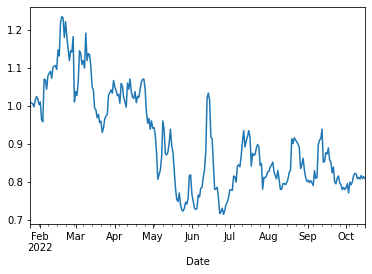

In [23]:
#strategy returns plot to view performance
strategy_returns = (1+date_close_df['Strategy Returns']).cumprod().plot()

In [24]:
#assign sma_fast and sma_slow columnns to DF feature X. 
X = date_close_df[['sma_fast', 'sma_slow']].shift().dropna()

X.head()

,sma_fast,sma_slow
Date,,
2022-01-25,36104.674805,52840.889531
2022-01-26,36228.846680,52594.893399
2022-01-27,36684.314453,52343.153828
2022-01-28,36899.671875,52071.916250
2022-01-29,37182.172851,51789.831211


In [26]:
#create target set that selects Signal column and assign to y 
y = date_close_df['signal']

y.value_counts()

-1.0    139
 1.0    127
Name: signal, dtype: int64

In [27]:
#select start of training period
training_start = X.index.min()

print(training_start)

2022-01-25 00:00:00


In [ ]:
test